在softmax回归的基础上实现，将模型网络换成多层感知机。
## 1.数据
数据跟softmax回归一样使用Fashion-MNIST图像分类数据集。

In [1]:
from d2l import mxnet as d2l
from mxnet import gluon, np, npx, autograd, init
from plotly.offline import plot, init_notebook_mode
import plotly.graph_objs as go
init_notebook_mode(connected=True)
npx.set_np()
ctx = npx.gpu() if (npx.num_gpus()) > 0 else mx.cpu()

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

## 2. 创建模型参数

+ 输入同样是28×28=784，输出同样是10个种类，这里添加一个具有256个隐藏单元的隐藏层。
+ 对于每一层都要有一个权重矩阵和一个偏差向量

In [2]:
num_inputs = 28*28
num_hiddens = 256
num_outputs = 10

W1 = np.random.normal(scale=0.01, size=(num_inputs, num_hiddens), ctx=ctx)
b1 = np.zeros(num_hiddens, ctx=ctx)
W2 = np.random.normal(scale=0.01, size=(num_hiddens, num_outputs), ctx=ctx)
b2 = np.zeros(num_outputs, ctx=ctx)
params = [W1, b1, W2, b2]

for param in params:
    param.attach_grad()

## 3.创建激活函数
通过使用maximum函数模拟ReLU激活函数

In [3]:
def relu(X):
    return np.maximum(X, 0)

## 4. 模型
因为我们不考虑空间结构，所以我们将reshape每个二维图像变成一个长度为long的平面向量num_inputs。

In [4]:
def net(X):
    X = X.reshape((-1, num_inputs))
    H = relu(np.dot(X, W1) + b1)
    return np.dot(H, W2) + b2

## 5.损失函数
利用高级API的集成函数来计算softmax和交叉熵损失

In [5]:
loss = gluon.loss.SoftmaxCrossEntropyLoss()

## 6.优化函数
适用sgd，学习效率0.1

In [6]:
lr = 0.1
def updater(batch_size):
    return d2l.sgd(params, lr, batch_size)

## 7. 训练
+ 训练10个epochs
+ 使用完成softmax时使用的训练模型

In [7]:
def accuracy(y_hat, y): 
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.astype(y.dtype) == y
    return float(d2l.reduce_sum(cmp))

def train_epoch(net, train_iter, loss, updater):
    
    l_sum = acc_rate = total = 0
    
    if isinstance(updater, gluon.Trainer):
        updater = updater.step
        
    for X,y in train_iter:
        X = X.copyto(ctx)
        y = y.copyto(ctx)
        with autograd.record():
            pre_y = net(X)
            l = loss(pre_y, y)
        l.backward()
        updater(y.size)
        l_sum += float(l.sum())
        acc_rate += accuracy(pre_y, y)
        total += y.size
    return l_sum/total, acc_rate/total

def evaluate_accuracy(net, data_iter):  

    match_num = total_num = 0
    for _, (X, y) in enumerate(data_iter):
        X = X.as_in_context(ctx)
        y = y.as_in_context(ctx)
        match_num += accuracy(net(X), y)
        total_num += y.size
    return match_num / total_num

def train(net, train_iter, test_iter, loss, epochs, updater):
    l_lst = []
    acc_lst = []
    test_acc_lst = []
    for epoch in range(epochs):
        l, acc = train_epoch(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        l_lst.append(l)
        acc_lst.append(acc)
        test_acc_lst.append(test_acc)
    assert l < 0.5, l
    assert acc <= 1 and acc > 0.7, acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc
    return [l_lst, acc_lst, test_acc_lst]

def draw_graph(result):
    data = []
    colors = ['aquamarine', 'orange', 'hotpink']
    names = ['train loss', 'train acc', 'test acc']
    symbols = ['circle-open', 'cross-open', 'triangle-up-open']
    for i, info in enumerate(result):
        trace = go.Scatter(
            x = list(range(1, num_epochs+1)),
            y = info,
            mode = 'lines+markers',
            name = names[i],
            marker = {
                'color':colors[i],
                'symbol':symbols[i],
            },
        )
        data.append(trace)
    fig = go.Figure(data = data)
    fig.show()

In [8]:
num_epochs = 10
result = train(net, train_iter, test_iter, loss, num_epochs, updater)

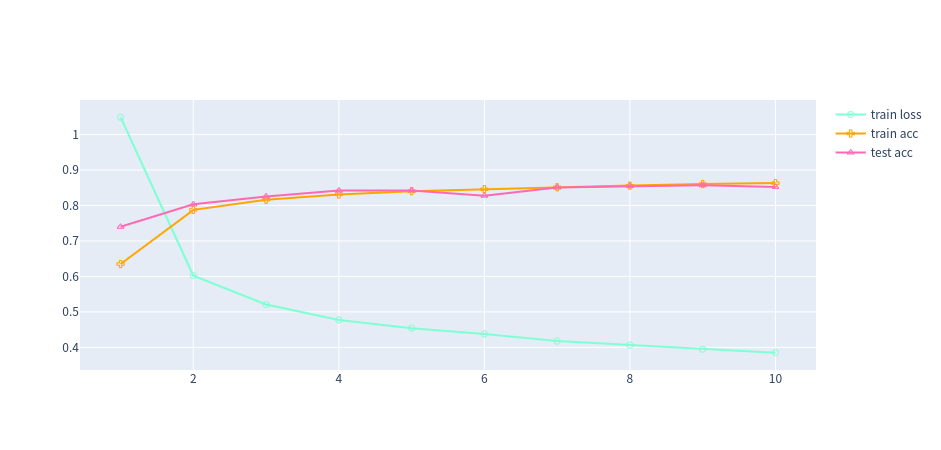

In [9]:
draw_graph(result)

## 8. 简化
与softmax的模型设置基本相同，就是在网络中添加一个256个隐藏单元的隐藏层。mxnet允许在神经层中指定激活函数，这点pytorch不同

In [10]:
from mxnet.gluon import nn
from mxnet import gluon
net = nn.Sequential()
net.add(nn.Dense(256, activation='relu'),
        nn.Dense(10))
net.initialize(init.Normal(sigma=0.01),ctx=ctx)

In [11]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr})

In [12]:
num_epochs=30
result = train(net, train_iter, test_iter, loss, num_epochs, trainer)

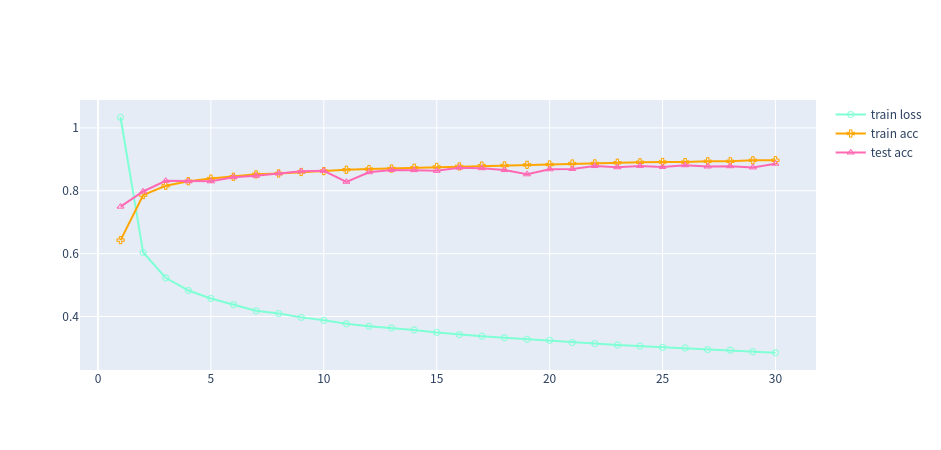

In [13]:
draw_graph(result)